In [1]:
!pip install -q transformers datasets evaluate accelerate gluonts ujson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/

In [2]:
!pip install -U datasets huggingface_hub fsspec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.


In [3]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from functools import lru_cache, partial
import pandas as pd
import numpy as np
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.time_feature import get_lags_for_frequency
from pandas.core.arrays.period import period_array
from transformers import InformerConfig, InformerForPrediction
from transformers import PretrainedConfig
from typing import Optional

from gluonts.transform.sampler import InstanceSampler


from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

from accelerate import Accelerator
from torch.optim import AdamW

from evaluate import load
from gluonts.time_feature import get_seasonality
from datetime import datetime
from tqdm import tqdm

In [4]:
tc_dataset = load_dataset("shaddie/thrust_curves_dataset")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

all_thrust_curves_window_data.json:   0%|          | 0.00/237k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/266 [00:00<?, ? examples/s]

In [5]:
# Specify train/test split fraction
train_fraction = 0.9  # 80% for training, 20% for testing

# Split the original training set into new train/test sets
split_dataset = tc_dataset["train"].train_test_split(train_size=train_fraction, seed=42)

In [6]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 239
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 27
    })
})

In [7]:
def find_pad_max(dataset):
    l=len(dataset)
    m = 0
    for r in range(l):
        # real = tc_dataset[split][r]['feat_dynamic_real']
        target = dataset[r]['target']
        if m < len(target):
            m = len(target)

    return m


def pad_data(data, m, split):
    l=len(data)
    tc = []
    for r in range(l):
        real = data[r]['feat_dynamic_real']
        target = data[r]['target']
        rlen = len(real)
        pad = [0 for _ in range(m-rlen)]
        # target = tc_dataset['train'][r]['target']
        real = real + pad
        target = target + pad
        tc.append({
            'start': data[r]['start'],
            'target': target,
            'feat_static_cat': data[r]['feat_static_cat'],
            'feat_dynamic_real': real,
            'item_id': data[r]['item_id']
                }
            )

    return tc

In [8]:
from datasets import Dataset
m1 = find_pad_max(split_dataset["train"])
m2 = find_pad_max(split_dataset["test"])
m = max(m1,m2)
print(m)

61


In [9]:
train_data = pad_data(split_dataset["train"], m=m, split="train")
test_data = pad_data(split_dataset["test"], m=m, split="test")

In [10]:
train_dataset = Dataset.from_list(train_data)
test_dataset = Dataset.from_list(test_data)

In [11]:
train_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 239
})

In [12]:
test_dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
    num_rows: 27
})

In [13]:
freq = "1W"
prediction_length = 8

# assert len(train_example["target"]) + prediction_length == len(
#     dataset["validation"][0]["target"]
# )

In [14]:
train_example = train_dataset[0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

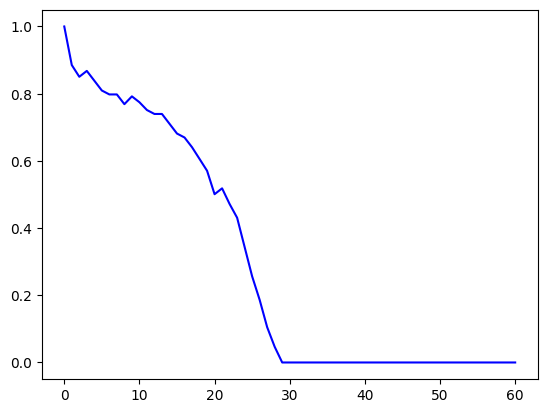

In [15]:
num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(
          # train_example["feat_dynamic_real"][-num_of_samples:],
          train_example["target"][-num_of_samples:],
          color="blue")

plt.show()

In [16]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [17]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [18]:
num_of_variates = len(test_dataset) # group according to the smaller test dataset size

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates
    # max_target_dim=num_of_variates,
    # num_test_dates=len(test_dataset),
    # num_test_dates=None, # len(test_dataset),
    # num_of_variates=num  # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)

In [19]:
multi_variate_train_example = multi_variate_train_dataset[0]
print(
    f"multi_variate_train_example['target'].shape = {multi_variate_train_example['target'].shape}"
)

multi_variate_train_example['target'].shape = (27, 99)


In [20]:
multi_variate_test_example = multi_variate_test_dataset[0]
print(
    f"multi_variate_test_example['target'].shape = {multi_variate_test_example['target'].shape}"
)

multi_variate_test_example['target'].shape = (27, 95)


In [21]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_month at 0x7eb9dbe8b9c0>, <function week_of_year at 0x7eb9dbe8bd80>]


Look back certain time range for each time step, as additional features "lags_sequence"

In [22]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 12, 51, 52, 53, 103, 104, 105, 155, 156, 157]


In [23]:
timestamp = pd.Period("2025-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [
    (time_feature.__name__, time_feature(timestamp_as_index))
    for time_feature in time_features
]
print(dict(additional_features))

{'day_of_month': array([-0.36666667]), 'week_of_year': array([-0.5])}


In [24]:
model = None

In [25]:
from transformers import InformerForPrediction

In [26]:
try:
    model = InformerForPrediction.from_pretrained("shaddie/rocketpill_thrustcurve_informer_model")
    print(f"successfully loaded model from hugging face with Config {model.config}")
except:
    print(f"An exception occurred when loading model from HF; initializing new model...")
    config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 24 * 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
    )

    model = InformerForPrediction(config)
    print(f"New model initialized with config {model.config}")

config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

successfully loaded model from hugging face with Config InformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "architectures": [
    "InformerForPrediction"
  ],
  "attention_dropout": 0.1,
  "attention_type": "prob",
  "cardinality": [
    0
  ],
  "context_length": 16,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 4,
  "distil": true,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 6,
  "feature_size": 111,
  "init_std": 0.02,
  "input_size": 27,
  "is_encoder_decoder": true,
  "lags_sequence": [
    1,
    168
  ],
  "loss": "nll",
  "model_type": "informer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 3,
  "prediction

In [27]:
model.config.distribution_output

'student_t'

In [28]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [29]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [30]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from all the possible transformed time series, 1 in our case)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [31]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # We create a test Instance splitter to sample the very last
    # context window from the dataset provided.
    instance_sampler = create_instance_splitter(config, "test")

    # We apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [32]:
config = model.config

In [33]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)


In [34]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 184, 3]) torch.FloatTensor
past_values torch.Size([256, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([256, 184, 27]) torch.FloatTensor
future_time_features torch.Size([256, 8, 3]) torch.FloatTensor
future_values torch.Size([256, 8, 27]) torch.FloatTensor
future_observed_mask torch.Size([256, 8, 27]) torch.FloatTensor


In [35]:
batch = next(iter(test_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([1, 184, 3]) torch.FloatTensor
past_values torch.Size([1, 184, 27]) torch.FloatTensor
past_observed_mask torch.Size([1, 184, 27]) torch.FloatTensor
future_time_features torch.Size([1, 8, 3]) torch.FloatTensor


In [36]:
def compute_mase_smape(forecasts):

  mase_metric = load("evaluate-metric/mase")
  smape_metric = load("evaluate-metric/smape")

  forecast_median = np.median(forecasts, 1).squeeze(0).T

  mase_metrics = []
  smape_metrics = []

  for item_id, ts in enumerate(test_dataset):
      training_data = ts["target"][:-prediction_length]
      ground_truth = ts["target"][-prediction_length:]
      mase = mase_metric.compute(
          predictions=forecast_median[item_id],
          references=np.array(ground_truth),
          training=np.array(training_data),
          periodicity=get_seasonality(freq),
      )
      mase_metrics.append(mase["mase"])

      smape = smape_metric.compute(
          predictions=forecast_median[item_id],
          references=np.array(ground_truth),
      )
      smape_metrics.append(smape["smape"])

  return np.mean(mase_metrics), np.mean(smape_metrics)

In [37]:
def test():
  model.eval()
  forecasts_ = []
  test_progress_bar = tqdm(test_dataloader, desc=f"Epoch ")
      # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
  for idx, batch in enumerate(test_progress_bar):
    # for k, v in batch.items():
    #   print(k, v.shape, v.type())
    # print(f'past_observed_mask {batch["past_observed_mask"].to(device).repeat(1,1, 3).shape}')
    # print(f'future_time_features {batch["future_time_features"].to(device).shape}')
    outputs = model.generate(
      static_categorical_features=batch["static_categorical_features"].to(device)
      if config.num_static_categorical_features > 0
      else None,
      static_real_features=batch["static_real_features"].to(device)
      if config.num_static_real_features > 0
      else None,
      past_time_features=batch["past_time_features"].to(device),
      past_values=batch["past_values"].to(device),
      future_time_features=batch["future_time_features"].to(device),
      past_observed_mask=batch["past_observed_mask"].to(device),
    )
  forecasts_.append(outputs.sequences.cpu().numpy())
  forecasts = np.vstack(forecasts_)

  mase, smape = compute_mase_smape(forecasts=forecasts)

  # print(f'mase: {mase} & smape: {smape}')

  return mase, smape


In [56]:
def training(epochs, model,
             device,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader
          ):

  loss_history = []

  device = accelerator.device

  model.to(device)
  optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)
  model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
  )

  model.train()
  for epoch in range(epochs):
    total_loss = 0.0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} total_loss {total_loss} ")
    # for data in tqdm(train_dataloader,  desc=f"Epoch {epoch+1}"):
    for idx, batch in enumerate(progress_bar):
        # print(f'idx: {idx}')
        # for k, v in batch.items():
        #     print(k, v.shape, v.type())
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss
        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / (progress_bar.n + 1))

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 200 == 0:
            mase, smape = test()
            print(f'Epoch {epoch} mape: {mase} & smape: {smape}  with loss: {loss.item()}')

  return model, loss_history






In [57]:
accelerator = Accelerator()
device = accelerator.device

In [58]:
model, loss_history = training(epochs=10, model=model, device=device)

Epoch 1/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-153]
Epoch : 1it [00:00, 10.65it/s]
Epoch 1/10 total_loss 0.0 : 2it [00:01,  1.54it/s, loss=-100]

Epoch 0 mape: 2.987835420960613 & smape: 1.999999689646555  with loss: -153.19314575195312


Epoch 1/10 total_loss 0.0 : 100it [00:13,  7.39it/s, loss=-214]
Epoch 2/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-222]
Epoch : 1it [00:00, 11.41it/s]
Epoch 2/10 total_loss 0.0 : 2it [00:01,  1.66it/s, loss=-219]

Epoch 1 mape: 3.049755613825025 & smape: 1.9999997185668152  with loss: -222.2519073486328


Epoch 2/10 total_loss 0.0 : 100it [00:13,  7.33it/s, loss=-223]
Epoch 3/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-224]
Epoch : 1it [00:00, 11.84it/s]
Epoch 3/10 total_loss 0.0 : 2it [00:01,  1.25it/s, loss=-220]

Epoch 2 mape: 2.9313253001681745 & smape: 1.999999702681114  with loss: -223.72044372558594


Epoch 3/10 total_loss 0.0 : 100it [00:13,  7.20it/s, loss=-223]
Epoch 4/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-221]
Epoch : 0it [00:00, ?it/s]
Epoch : 1it [00:00,  9.10it/s]
Epoch 4/10 total_loss 0.0 : 2it [00:01,  1.52it/s, loss=-222]

Epoch 3 mape: 2.9338417817863824 & smape: 1.9999997049774285  with loss: -220.69512939453125


Epoch 4/10 total_loss 0.0 : 100it [00:16,  6.12it/s, loss=-224]
Epoch 5/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-227]
Epoch : 1it [00:00, 10.88it/s]
Epoch 5/10 total_loss 0.0 : 2it [00:01,  1.62it/s, loss=-221]

Epoch 4 mape: 2.9260773423694495 & smape: 1.9999997004380707  with loss: -226.85696411132812


Epoch 5/10 total_loss 0.0 : 100it [00:13,  7.31it/s, loss=-224]
Epoch 6/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-219]
Epoch : 1it [00:00, 11.78it/s]
Epoch 6/10 total_loss 0.0 : 2it [00:01,  1.64it/s, loss=-223]

Epoch 5 mape: 2.883863965662359 & smape: 1.9999996945440424  with loss: -219.31117248535156


Epoch 6/10 total_loss 0.0 : 100it [00:13,  7.24it/s, loss=-225]
Epoch 7/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-222]
Epoch : 1it [00:00, 11.59it/s]
Epoch 7/10 total_loss 0.0 : 2it [00:01,  1.64it/s, loss=-227]

Epoch 6 mape: 2.946814090629129 & smape: 1.9999997039122035  with loss: -222.18106079101562


Epoch 7/10 total_loss 0.0 : 100it [00:21,  4.58it/s, loss=-225]
Epoch 8/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-218]
Epoch : 1it [00:00, 10.15it/s]
Epoch 8/10 total_loss 0.0 : 2it [00:01,  1.65it/s, loss=-223]

Epoch 7 mape: 2.9212929591311245 & smape: 1.9999997058854473  with loss: -218.47103881835938


Epoch 8/10 total_loss 0.0 : 100it [00:13,  7.35it/s, loss=-226]
Epoch 9/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-211]
Epoch : 1it [00:00, 11.45it/s]
Epoch 9/10 total_loss 0.0 : 2it [00:01,  1.62it/s, loss=-218]

Epoch 8 mape: 2.974412496843028 & smape: 1.9999997097398647  with loss: -210.5684051513672


Epoch 9/10 total_loss 0.0 : 100it [00:13,  7.40it/s, loss=-223]
Epoch 10/10 total_loss 0.0 : 0it [00:00, ?it/s, loss=-237]
Epoch : 1it [00:00, 11.77it/s]
Epoch 10/10 total_loss 0.0 : 2it [00:01,  1.67it/s, loss=-236]

Epoch 9 mape: 2.957837312665748 & smape: 1.9999997061740988  with loss: -236.81881713867188


Epoch 10/10 total_loss 0.0 : 100it [00:13,  7.38it/s, loss=-224]


In [ ]:
# import os
# work_dir = os.getcwd()
# work_dir = os.getcwd()
# data_dir = work_dir.replace("GitHub/RocketPill/ipynb-notebooks", "Data/")

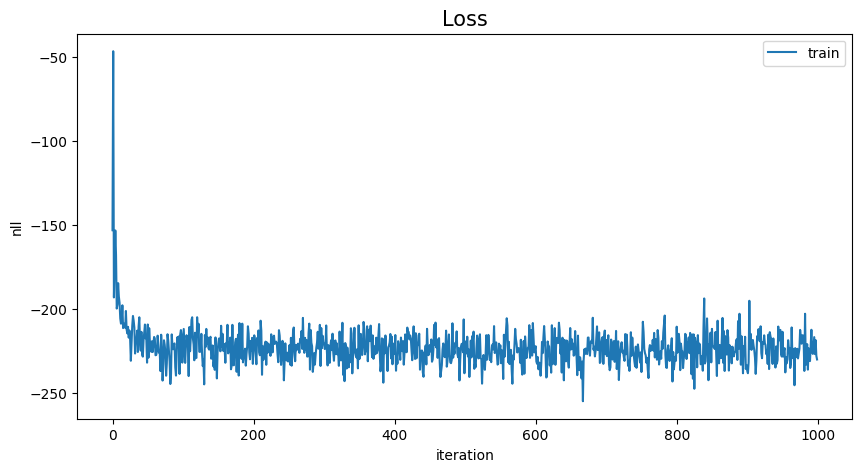

In [59]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
# plt.savefig(data_dir+"hf_informer4roqeto_loss_curve_"+str(datetime.now()).replace(":",".")+".png")
plt.show()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
model.push_to_hub("shaddie/rocketpill_thrustcurve_informer_model",
                  use_auth_token=True,
                  commit_message="training-time-series-thrust-curve",
                  private=False)